# Seattle Fremont Bridge Bike Data
7/23/2017 *fremont.ipynb*

Credit: https://github.com/jakevdp/JupyterWorkflow

## Set up

In [1]:
import os
from urllib.request import urlretrieve
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

## Get data

In [2]:
# get data if not already downloaded
url = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
filename = 'fremont.csv'
force = False
if force or not os.path.exists(filename): 
    urlretrieve(url, filename)

In [3]:
# create dataframe, use Date column as index

# can parse on import but very slow, replaced with conversion in next cell to speed up
# data = pd.read_csv(filename, index_col='Date', parse_dates=True) 

data = pd.read_csv(filename, index_col='Date')

In [4]:
# convert Date column to datetime, try statement is faster, except statement is foolproof
# reference: http://strftime.org/

try:
    data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
except TypeError:
    data.index = pd.to_datetime(data.index)

In [5]:
# rename columns
data.columns = ['West', 'East']

In [6]:
# check data shape
data.shape

(41568, 2)

In [7]:
# view some data
data.head()

,West,East
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [8]:
# view some data
data.tail()

,West,East
Date,,
2017-06-30 19:00:00,225.0,82.0
2017-06-30 20:00:00,119.0,43.0
2017-06-30 21:00:00,87.0,38.0
2017-06-30 22:00:00,58.0,22.0
2017-06-30 23:00:00,36.0,13.0


## Exploratory analysis

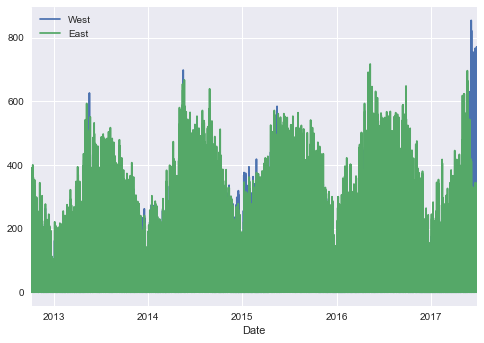

In [9]:
# riders by day
# very dense plot
data.plot()

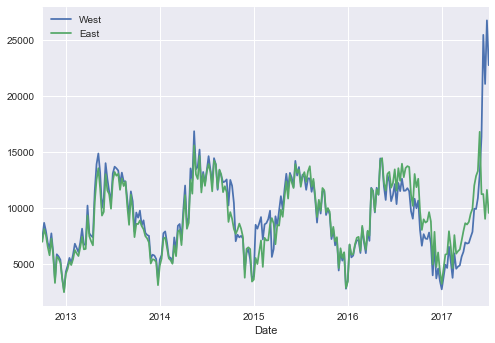

In [10]:
# riders by week
# summarize data by week
data.resample('w').sum().plot()

In [11]:
# add Total column to dataframe
data['Total'] = data['West'] + data['East']

(0, 1059460.05)

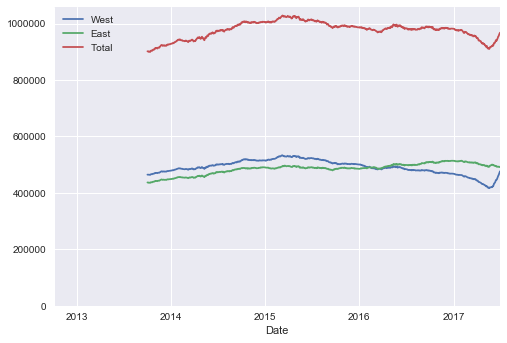

In [12]:
# riders by year
# resample by rolling 365 days to look for annual trends
ax = data.resample('d').sum().rolling(365).sum().plot()
# set y axis to zero to avoid misinterpretation
ax.set_ylim(0, None)

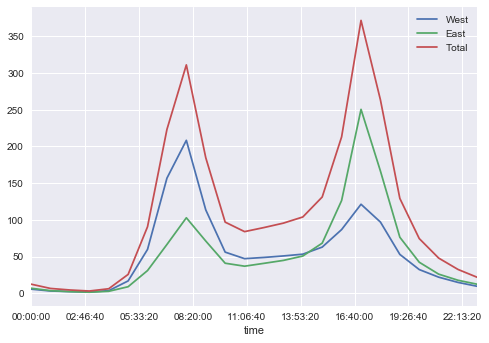

In [13]:
# riders by time of day, shows commuters
data.groupby(data.index.time).mean().plot()

In [14]:
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date )
pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


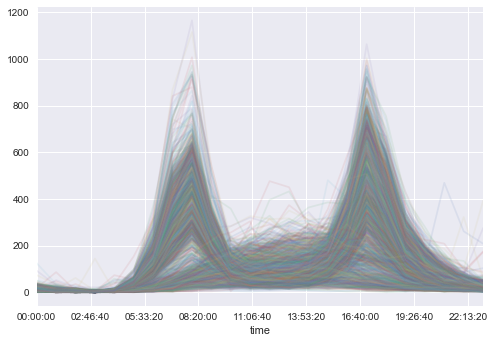

In [15]:
# every day by time of day, note two patterns
pivoted.plot(legend=False, alpha=0.1)

## Principal component analysis

In [16]:
# 24 observations for each day
pivoted.shape

(24, 1732)

In [17]:
# 1732 observations for each hour
x = pivoted.fillna(0).T.values
x.shape

(1732, 24)

In [18]:
# make data two dimensional
x2 = PCA(2, svd_solver='full').fit_transform(x)
x2.shape

(1732, 2)

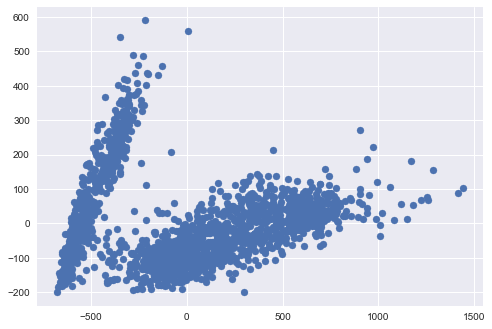

In [19]:
# note two different patterns of days
plt.scatter(x2[:, 0], x2[:, 1])

## Unsupervised clustering

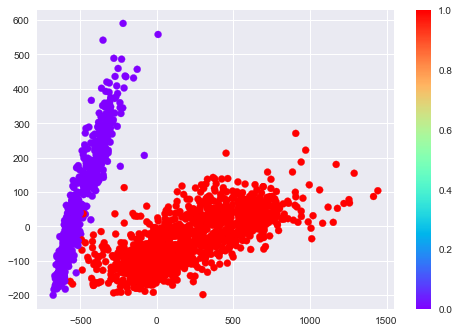

In [20]:
# color data by cluster
gmm = GaussianMixture(2).fit(x)
labels = gmm.predict(x)
plt.scatter(x2[:, 0], x2[:, 1], c=labels, cmap='rainbow')
plt.colorbar();

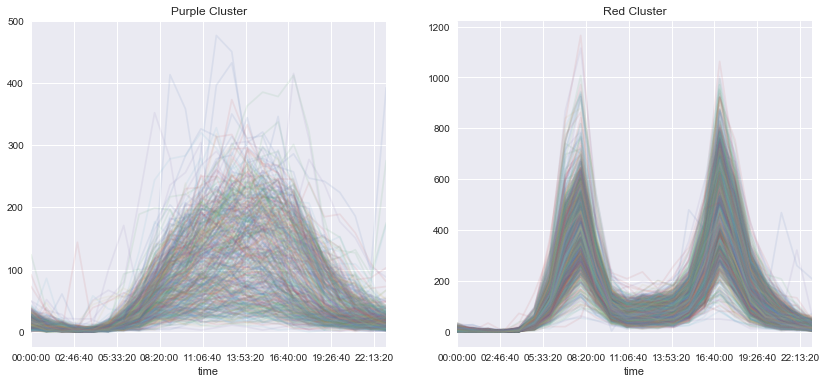

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1, ax=ax[0]);
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[1]);

ax[0].set_title('Purple Cluster') # weekend pattern?
ax[1].set_title('Red Cluster');   # weekday pattern?

## Comparing with day of week

In [22]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

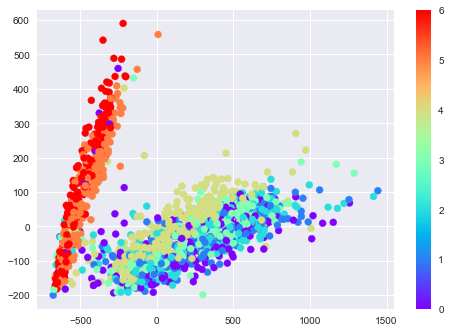

In [23]:
plt.scatter(x2[:, 0], x2[:, 1], c=dayofweek, cmap='rainbow')
plt.colorbar();

## Analyzing outliers

In [28]:
# outliers are public holidays?
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 0) & (dayofweek < 5)]

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29'],
              dtype='datetime64[ns]', freq=None)